# Tutorial: PASCode-ScorePrediction
 PASCode uses a Graph Attention Network (GAT) to predict Phenotype Associated Cell (PAC) scores for single cells. The GAT model is trained using aggregated cell labels calculated from Robust Rank Aggregation (RRA).

 There are several scenarios where using GAT for PAC scoring is preferable:
 1. **Imbalanced Phenotype Conditions**:
    In population-scale datasets where the number of subjects in different phenotype conditions (e.g., disease vs. control) is highly imbalanced, users can sample a balanced subset. The GAT model is trained on this balanced subset and then used to annotate PAC scores for the entire dataset. This could mitigate the low performance of DA and RRA due to phenotype imbalance, as demonstrated in our benchmarking results.
 2. **Fast PAC Score Annotation:**
    Inference using a trained GAT model is significantly faster than running multiple DA methods. This approach provides an efficient alternative for directly annotating PAC scores.
 3. **Predicting for Unseen Data or Data with Missing Phenotype Labels:**
    Train a GAT model on one dataset and use it to predict PAC scores for unseen datasets with the same contrastive phenotypes. We demonstrated this in our experiments using GAT trained on PsychAD (AD vs Control) to predict AD PAC scores for the ROSMAP and SEA-AD datasets.
 4. **Annotating PAC Scores for Multi-Class Labels:**
    In scenarios where PAC scores are needed for multi-class labels of a progressive condition, such as AD progression, as demonstrated in our analysis, one can train a GAT model on samples with the least and most advanced phenotypic groups (e.g., braak 0 and braak 6), and predict on the rest samples, to gain a view of the overall trend.

## Preparation

### Import

In [1]:
import PASCode
import scanpy as sc

### Load Data

In [2]:
DATA_PATH = "./data/"
adata = sc.read_h5ad(DATA_PATH + 'synth_demo_2v6_sparse.h5ad')
adata.X = adata.X.toarray()
print(adata)

AnnData object with n_obs × n_vars = 11674 × 2000
    obs: 'celltype', 'phenotype', 'subject_id'


### Specify Column Names for Metadata
 Define the column names for subject IDs, conditions, and positive/negative conditions.

In [ ]:
# Column specifications
subid_col = 'subject_id'   # subject ID column
cond_col = 'phenotype'     # condition column
pos_cond = 'cond1'         # positive condition (e.g., disease)
neg_cond = 'cond2'         # negative condition (e.g., control)

### (Optional) Subsample Subjects
 **Recommendation:** When dealing with imbalanced phenotype conditions, subsampling to obtain an equal number of subjects in each condition can improve accuracy, as demonstrated in our experiments.

In [ ]:
adata_sub = PASCode.utils.subsample_donors(
    adata=adata,
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    subsample_num=None,  # Automatically subsample to the smaller number of subjects in the two conditions
    sex_col=None, # can specify the sex column in adata.obs to account for subject's sex balance
)
print(f"Subsampled dataset: {adata_sub}")

Before donor subsampling:
phenotype
cond2    6
cond1    2
Name: count, dtype: int64
'subsample_num' not provided. Automatically subsample to the minimum number of subjects in the two conditions.
Donor subsampling:  2:2
After donor subsampling:
phenotype
cond2    2
cond1    2
Name: count, dtype: int64
Subsampled dataset: AnnData object with n_obs × n_vars = 5942 × 2000
    obs: 'celltype', 'phenotype', 'subject_id'


### RRA for Aggregated Phenotype Labels
 Calculate aggregated phenotype labels for each cell using selected DA methods followed by RRA. 
 
 PASCode constructs graphs based on PCA representations (`adata.obsm['X_pca']`) and neighborhood information (`adata.obsp['connectivities']`). If users wish to use a different representation or graph-building method, ensure that the relevant fields in `adata.obsm` and `adata.obsp` are assigned.

In [5]:
adata_sub.obs['aggreg_label'] = PASCode.da.agglabel(
    adata_sub,
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    da_methods=['milo', 'meld', 'daseq']  # Selected DA methods
)

============================= DA and RRA... =============================
'use_pre' not found in adata.obsm.
Scaling...
Running PCA...
Computing connectivities...



----------------------------- Milo started ... -----------------------------
Making neighborhoods...
Counting neighborhoods...
Running differential abundance testing...
----------------------------- Milo Time cost (s):  3.13  -----------------------------


 ----------------------------- MELD started ... -----------------------------
Building graph on 5942 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.44 seconds.
  Calculating affinities...
  Calculated affinities in 0.16 seconds.
Calculated graph and diffusion operator in 2.03 seconds.
----------------------------- MELD Time cost (s):  2.22  -----------------------------


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
----------------------------- DAseq started ... -----------------------------
Calculating DA 

### Assign Aggregated Labels to the Entire Dataset
 Transfer the aggregated labels from the subsampled dataset back to the original dataset. This step is crucial for GAT training.

In [6]:
adata.obs.loc[adata_sub.obs.index, 'aggreg_label'] = adata_sub.obs['aggreg_label']

## Train a GAT model

### Prepare Training and Validation Masks
 Create training and validation masks. Users can customize options such as specifying sex column name to account for sex balance and setting validation set size (see the docstring of `get_val_mask()` for more details).

In [7]:
PASCode.model.get_val_mask(
    adata_sub, 
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond
)

TAG
AACTGGTGTACCGGCT.1     False
AAGACCTAGTTAACGA.1     False
ACATCAGCAGGCTCAC.1     False
ACGAGGATCCATTCTA.1     False
CAAGGCCTCCGGGTGT.1     False
                       ...  
AGGTCATTCTATCCTA.36     True
CGTCACTCATAAGACA.38    False
GCCTCTACACTTAACG.44    False
CACACTCTCTCTGAGA.48    False
TGCCCATAGTAGGTGC.48    False
Name: val_mask, Length: 5942, dtype: bool

Assign masks back to the original dataset. This step is important to enable GAT training.

In [8]:
# Assign masks to the original dataset
adata.obs['val_mask'] = adata.obs.index.isin(
    adata_sub.obs[adata_sub.obs['val_mask']].index
)
adata.obs['train_mask'] = adata.obs.index.isin(
    adata_sub.obs[adata_sub.obs['train_mask']].index
)

### Train the GAT Model

In [9]:
model = PASCode.model.train_model(
    adata=adata,
    agglabel_col='aggreg_label',
    device='cpu' # NOTE change accordingly
)

No graph connectivities found in adata.obsp.
Scaling data...
Running PCA...
Builidng graph...
Building graph time cost (s): 32.046832.
Constructing batches...


Computing METIS partitioning...
Done!


Batch construction done.

============================= Training GAT... =============================
Epoch: 1/100 - lr: 1.000e-03 - train_loss: 0.427 - val_loss: 0.333 
Epoch: 2/100 - lr: 1.000e-03 - train_loss: 0.194 - val_loss: 0.208 
Epoch: 3/100 - lr: 1.000e-03 - train_loss: 0.140 - val_loss: 0.195 
Epoch: 4/100 - lr: 1.000e-03 - train_loss: 0.121 - val_loss: 0.197 
Epoch: 5/100 - lr: 1.000e-03 - train_loss: 0.117 - val_loss: 0.234 
Epoch: 6/100 - lr: 1.000e-03 - train_loss: 0.110 - val_loss: 0.162 
Epoch: 7/100 - lr: 1.000e-03 - train_loss: 0.103 - val_loss: 0.172 
Epoch: 8/100 - lr: 1.000e-03 - train_loss: 0.097 - val_loss: 0.180 
Epoch: 9/100 - lr: 1.000e-03 - train_loss: 0.091 - val_loss: 0.168 
Epoch: 10/100 - lr: 5.000e-04 - train_loss: 0.087 - val_loss: 0.159 
Epoch: 11/100 - lr: 5.000e-04 - train_loss: 0.090 - val_loss: 0.169 
Epoch: 12/100 - lr: 5.000e-04 - train_loss: 0.081 - val_loss: 0.181 
Epoch: 13/100 - lr: 5.000e-04 - train_loss: 0.079 - val_loss: 0.168 
Epoch: 14/

## Predicting PAC Scores Using the Trained GAT Model

### Predict PAC Scores for the Entire Dataset
 Use the trained GAT model to predict PAC scores for all single cells in the original dataset.

In [10]:
adata.obs['PAC_score'] = model.predict(adata)
print(f"PAC scores predicted and added to `adata.obs`.")

Building PyTorch Geometric Data...
PAC scores predicted and added to `adata.obs`.


### Visualize the PAC Scores

In [11]:
sc.tl.umap(adata)

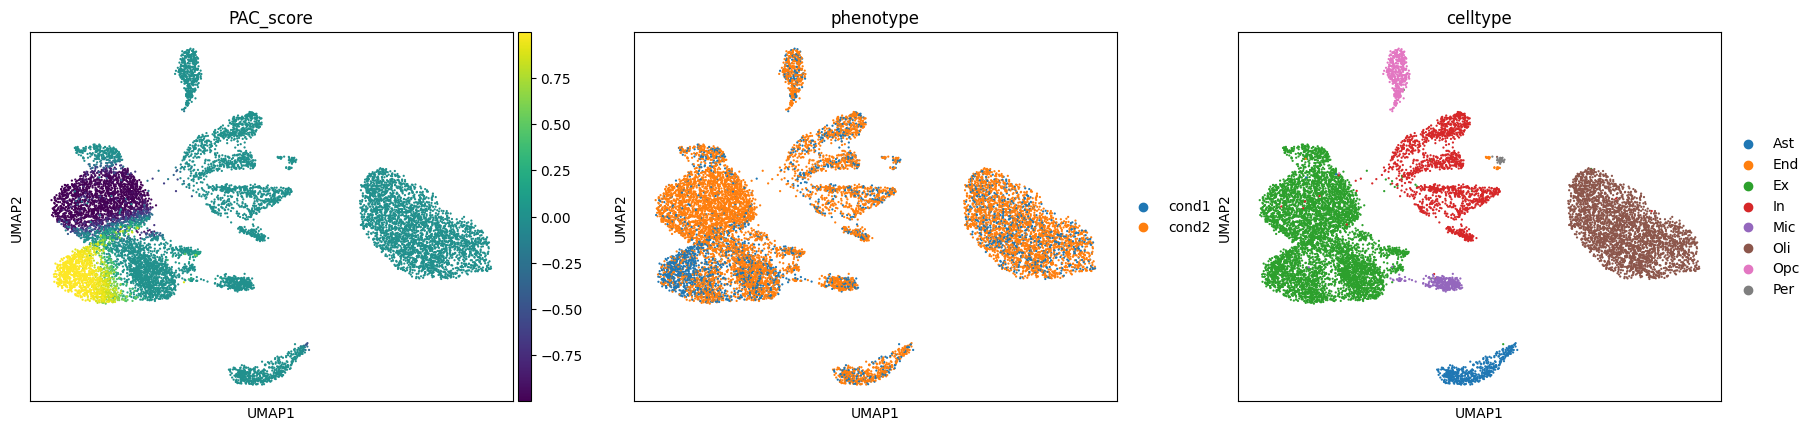

In [12]:
sc.pl.umap(adata, color=['PAC_score', 'phenotype', 'celltype'])

## Using Pretrained Models for PAC Score Annotations
PASCode provides pretrained GAT models trained on PsychAD consortium data for direct PAC score annotations.
 
#### When using pretrained GAT models is not recommended:
- The user values PAC score accuracy more than running speed. Although the DA methods and GAT training can take longer time to run for large datasets, they give more accurate PAC score annotations, unaffected by factors such as batch effect or gene set differences.

#### When using pretrained GAT models is recommended:
- The dataset has unknown/missing subject condition labels, which are usually required by DA methods. In this case, for instance, one can directly use the AD GAT pretrained model to infer AD-PAC scores.
- The user values running speed more than PAC score accuracy.

#### Load Data
 Load the `AnnData` object containing your dataset.

In [13]:
adata = sc.read_h5ad(DATA_PATH + "ROSMAP_12v12_sparse.h5ad")
adata.X = adata.X.toarray()
print(adata)

AnnData object with n_obs × n_vars = 23986 × 5000
    obs: 'TAG', 'tsne1', 'tsne2', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'V1', 'fastq', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'individualID', 'diagnosis', 'bkd'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'


#### Align Genes to PsychAD Pretrained Model
 The pretrained models are based on specific gene sets of PsychAD. Align the dataset's genes to match the pretrained model's gene set.

In [14]:
adata = PASCode.utils.align_psychad_gene(adata)

No graph found in adata. Building graph using PCA...
Scaling data...
Running PCA...
Builidng graph...
Building graph time cost (s): 3.474947.


#### Load the Pretrained GAT Model

In [15]:
state_dict_path = "./pretrained_models/model_state_dict_ADvsControl.pt"
pretrained_model = PASCode.model.load_model(state_dict_path)

### Predict PAC Scores

In [16]:
adata.obs['PAC_score'] = pretrained_model.predict(adata)

Building PyTorch Geometric Data...


### Visualize PAC Scores

In [ ]:
sc.tl.umap(adata)

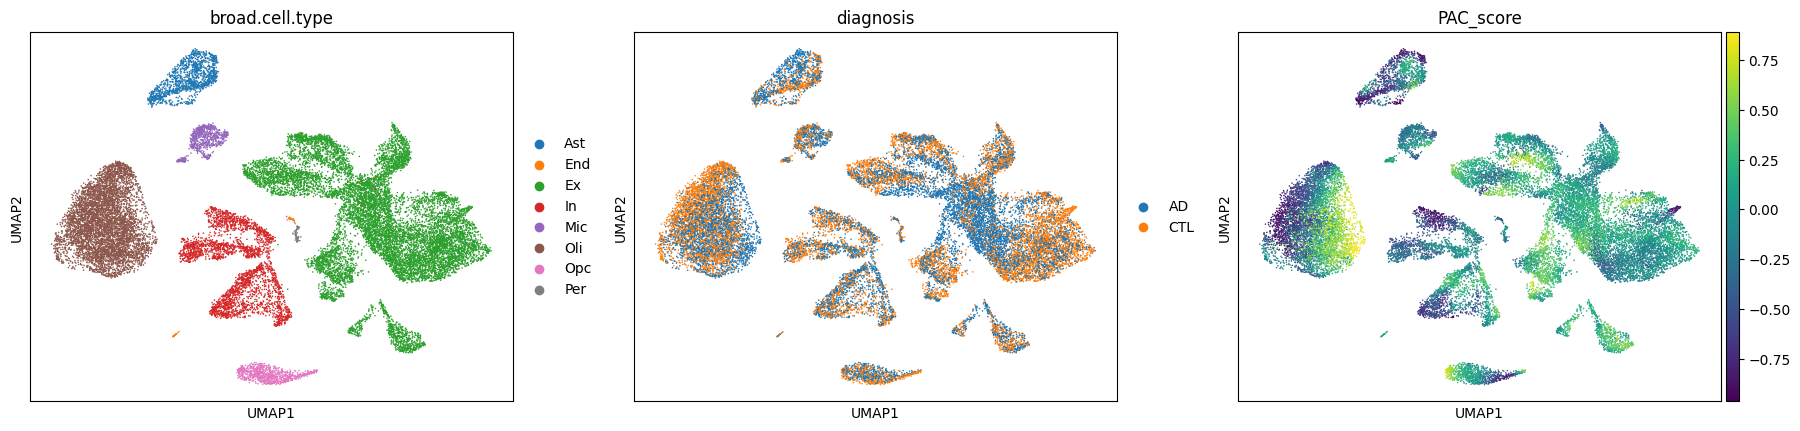

In [18]:
sc.pl.umap(adata, color=['broad.cell.type', 'diagnosis', 'PAC_score'])